TODO 

---
-run with everything same, just adding dropout layers
try with going 30 min before for 30 min
-implement SVM
-implement ANN
-implement transformers


#Setting up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive

/content/drive


In [ ]:
%cd Shareddrives/blisssinghal-dataset/

/content/drive/Shareddrives/blisssinghal-dataset


In [ ]:
%pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Importing Libraries

In [ ]:
import glob
import numpy as np
import pandas as pd
import mne
import os
import matplotlib.pyplot as plt
import sklearn 
import keras
import pickle
import pickletools
import sklearn.neighbors
import sklearn.metrics

Importing specific libraries from keras 

In [ ]:
from keras.layers import (LSTM, Dense, RNN, Flatten, Dropout, SimpleRNN, Conv1D)
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers


#Data Extraction

##Extracting the names of the files from a given folder

In [ ]:
def extract_files(folder):
    file_names = glob.glob(f"Dataset/{folder}/*.edf")
    return file_names

##Extracting the names of files from all folders

In [ ]:
def extract_all_files():
    names = []
    for i in range(24):
        if (i + 1 < 10):
            names.append(extract_files(f"chb0{i+1}"))
        else:
             names.append(extract_files(f"chb{i+1}"))
    return names

In [ ]:
names = extract_all_files()
print(names)

[['Dataset/chb01/chb01_25.edf', 'Dataset/chb01/chb01_13.edf', 'Dataset/chb01/chb01_18.edf', 'Dataset/chb01/chb01_42.edf', 'Dataset/chb01/chb01_36.edf', 'Dataset/chb01/chb01_21.edf', 'Dataset/chb01/chb01_04.edf', 'Dataset/chb01/chb01_39.edf', 'Dataset/chb01/chb01_02.edf', 'Dataset/chb01/chb01_05.edf', 'Dataset/chb01/chb01_43.edf', 'Dataset/chb01/chb01_24.edf', 'Dataset/chb01/chb01_14.edf', 'Dataset/chb01/chb01_33.edf', 'Dataset/chb01/chb01_23.edf', 'Dataset/chb01/chb01_46.edf', 'Dataset/chb01/chb01_26.edf', 'Dataset/chb01/chb01_22.edf', 'Dataset/chb01/chb01_09.edf', 'Dataset/chb01/chb01_32.edf', 'Dataset/chb01/chb01_38.edf', 'Dataset/chb01/chb01_34.edf', 'Dataset/chb01/chb01_27.edf', 'Dataset/chb01/chb01_40.edf', 'Dataset/chb01/chb01_41.edf', 'Dataset/chb01/chb01_12.edf', 'Dataset/chb01/chb01_31.edf', 'Dataset/chb01/chb01_19.edf', 'Dataset/chb01/chb01_10.edf', 'Dataset/chb01/chb01_29.edf', 'Dataset/chb01/chb01_30.edf', 'Dataset/chb01/chb01_17.edf', 'Dataset/chb01/chb01_37.edf', 'Dataset

##Flattening the names array

In [ ]:
def flatten(names):
    new_array = []
    for i in range(len(names)):
        for j in range(len(names[i])):
            new_array.append(names[i][j])
    return new_array

In [ ]:
names = flatten(names)

In [ ]:
#converting names into numpy array
names = np.asarray(names)
print(names.shape)


(619,)


getting the foldername from the file name

In [ ]:
def get_folder_name(file_name):
    folder_name, num = file_name.split("_")
    return folder_name

Seperating the Data into seizure data and non seizure data

##Getting the seizure file names from the records

In [ ]:
def get_record_names(filepath):
    names = pd.read_csv(filepath)
    names = names.values.tolist()
    return names

In [ ]:
seizure_names = get_record_names("Dataset/records_seizures.csv")
print(seizure_names)


[['chb01/chb01_04.edf'], ['chb01/chb01_15.edf'], ['chb01/chb01_16.edf'], ['chb01/chb01_18.edf'], ['chb01/chb01_21.edf'], ['chb01/chb01_26.edf'], ['chb02/chb02_16.edf'], ['chb02/chb02_16+.edf'], ['chb02/chb02_19.edf'], ['chb03/chb03_01.edf'], ['chb03/chb03_02.edf'], ['chb03/chb03_03.edf'], ['chb03/chb03_04.edf'], ['chb03/chb03_34.edf'], ['chb03/chb03_35.edf'], ['chb03/chb03_36.edf'], ['chb04/chb04_05.edf'], ['chb04/chb04_08.edf'], ['chb04/chb04_28.edf'], ['chb05/chb05_06.edf'], ['chb05/chb05_13.edf'], ['chb05/chb05_16.edf'], ['chb05/chb05_17.edf'], ['chb05/chb05_22.edf'], ['chb06/chb06_01.edf'], ['chb06/chb06_04.edf'], ['chb06/chb06_09.edf'], ['chb06/chb06_10.edf'], ['chb06/chb06_13.edf'], ['chb06/chb06_18.edf'], ['chb06/chb06_24.edf'], ['chb07/chb07_12.edf'], ['chb07/chb07_13.edf'], ['chb07/chb07_18.edf'], ['chb08/chb08_02.edf'], ['chb08/chb08_05.edf'], ['chb08/chb08_11.edf'], ['chb08/chb08_13.edf'], ['chb08/chb08_21.edf'], ['chb09/chb09_06.edf'], ['chb09/chb09_08.edf'], ['chb09/chb09_

Formatting the seizure names the same way they are formatted in the data array

In [ ]:
def format_seizure_names(names):
    formated = []
    for array in names:
        for name in array:
            folder, file = name.split("/")
            name2 = f"Dataset/{folder}\\{file}"
            formated.append(name2)
    return formated

In [ ]:
seizure_names = format_seizure_names(seizure_names)
print(seizure_names)

['Dataset/chb01\\chb01_04.edf', 'Dataset/chb01\\chb01_15.edf', 'Dataset/chb01\\chb01_16.edf', 'Dataset/chb01\\chb01_18.edf', 'Dataset/chb01\\chb01_21.edf', 'Dataset/chb01\\chb01_26.edf', 'Dataset/chb02\\chb02_16.edf', 'Dataset/chb02\\chb02_16+.edf', 'Dataset/chb02\\chb02_19.edf', 'Dataset/chb03\\chb03_01.edf', 'Dataset/chb03\\chb03_02.edf', 'Dataset/chb03\\chb03_03.edf', 'Dataset/chb03\\chb03_04.edf', 'Dataset/chb03\\chb03_34.edf', 'Dataset/chb03\\chb03_35.edf', 'Dataset/chb03\\chb03_36.edf', 'Dataset/chb04\\chb04_05.edf', 'Dataset/chb04\\chb04_08.edf', 'Dataset/chb04\\chb04_28.edf', 'Dataset/chb05\\chb05_06.edf', 'Dataset/chb05\\chb05_13.edf', 'Dataset/chb05\\chb05_16.edf', 'Dataset/chb05\\chb05_17.edf', 'Dataset/chb05\\chb05_22.edf', 'Dataset/chb06\\chb06_01.edf', 'Dataset/chb06\\chb06_04.edf', 'Dataset/chb06\\chb06_09.edf', 'Dataset/chb06\\chb06_10.edf', 'Dataset/chb06\\chb06_13.edf', 'Dataset/chb06\\chb06_18.edf', 'Dataset/chb06\\chb06_24.edf', 'Dataset/chb07\\chb07_12.edf', 'Datas

Getting the healthy file names by deleting the file names that are the ones with seizures

In [ ]:
def get_healthy_names(all_names, seizure_names):
    healthy = []
    for folder in all_names:
        for name1 in folder:
            seizure = False
            for name2 in seizure_names:
                if (name1 == name2):
                    seizure = True
            if (not seizure):
                healthy.append(name1)
    return healthy

In [ ]:
healthy_names = get_healthy_names(names, seizure_names)

##going thru the all the summary files to get the start and stop times and files of the seizure

Finding the seizure files in the summary file

In [ ]:
def get_seizure_files_summary(summary, seizure_names):
    files = []
    seizure_files = []
    summary = open(summary, "r")
    for line in summary:
        for word in line.split(" "):
            for w in (word):
                if w == ".":
                    files.append(word)
    for file in files:
        file = "Dataset/chb21\\" + file
        for seizure_name in seizure_names:
            if (file.split(" ")[0] == seizure_name.split()[0]):
                seizure_files.append(file)
    return seizure_files

getting seizure start and end times

In [ ]:
def get_seizure_time(summary, seizure_files):
    start = []
    end = []
    summary = open(summary, "r")
    for line in summary:
        words = line.split(" ")
        if "Seizure" in line and "Start" in line:
            start.append(words[len(words) - 2])
        elif "Seizure" in line and "End" in line:
            end.append(words[len(words) - 2])
    return start, end
    

get summary file in a particular dataset folder, like chb01

In [ ]:
def get_summary_file(data_folder):
    for file in os.listdir(data_folder):
        #checking to see if it has summary
        if len(str(file).split("-")) > 1:
            return file

find the ones that are .edf

In [ ]:
def get_edf_files(files):
    edf_files = []
    for file in files:
        if len(file.split(".")) == 2 and file.split(".")[1] == "edf":
            edf_files.append(file)
    return edf_files

getting the total time of the files that is before the seizure file

In [ ]:
def get_time(file_reading, line_index): 
    line = file_reading[line_index] 
    words = line.split(" ")
    time = words[len(words) - 1]
    return time

##Extracting the data from the files using mne

In [ ]:
def get_data(filename):
    data = mne.io.read_raw_edf(filename, preload = True)
    mne.channels.make_1020_channel_selections(data.info)
    data.set_eeg_reference()
    epochs = mne.make_fixed_length_epochs(data, duration = 5, overlap=1)
  
    return data, epochs

##Ordering the files based on the file start and end time

In [ ]:
#getting the file start times
def get_file_start(summary):
    file_order = {}
    file_end = []
    summary = open(summary, "r")
    lines = summary.readlines()
    for index in range(len(lines)):
        words = (lines[index]).split(" ")
        if "File Name" in lines[index]:
            name = words[2].strip()
        if "File Start" in lines[index]:
            time = words[3].strip()
            file_order.update({time:name})
            #convert time and name back to nothing
            time = ""
            name = ""
        if "File End" in lines[index]:
            end = words[3].strip()
            file_end.append(end)
            
    return file_order, file_end
        

In [ ]:
summary_file = "Dataset/chb01/chb01-summary.txt"

In [ ]:
file_order, file_end = get_file_start(summary_file)

In [ ]:
print(file_end)

['14:43:04', '15:43:12', '16:43:19', '17:43:26', '18:43:33', '19:43:40', '1:44:37', '2:44:44', '3:44:51', '4:44:59', '5:45:06', '6:45:13', '7:29:43', '8:33:46', '9:33:49', '10:33:58', '11:34:06', '12:34:14', '13:13:07']


In [ ]:
print(file_order)

{'13:43:04': 'chb01_03.edf', '14:43:12': 'chb01_04.edf', '15:43:19': 'chb01_05.edf', '16:43:26': 'chb01_06.edf', '17:43:33': 'chb01_07.edf', '18:43:40': 'chb01_08.edf', '00:44:37': 'chb01_14.edf', '01:44:44': 'chb01_15.edf', '02:44:51': 'chb01_16.edf', '03:44:59': 'chb01_17.edf', '04:45:06': 'chb01_18.edf', '05:45:13': 'chb01_19.edf', '06:45:20': 'chb01_20.edf', '07:33:46': 'chb01_21.edf', '08:33:49': 'chb01_22.edf', '09:33:58': 'chb01_23.edf', '10:34:06': 'chb01_24.edf', '11:34:14': 'chb01_25.edf', '12:34:22': 'chb01_26.edf'}


extracting the hr val

In [ ]:
def get_hr(time):
    hr, minute, sec = time.split(":")
    hr_int = float(hr) * 3600
    min_float = float(minute) * 60
    sec_float = float(sec)
    final = hr_int + min_float + sec_float
    return final

Sorting the hr times

In [ ]:
def sort_hr(hours):
    return hours.sort()
    

In [ ]:
def sort_by_time(summary):
    file_order, file_end = get_file_start(summary)
    new_file_order = {}
    hours = []
    for time, file in file_order.items():
        hour = get_hr(time)
        hours.append(hour)
        new_file_order.update({hour:file})
    hours2 = sorted(hours)
    sorted_list = {}
    for hour in hours2:
        for time, file in new_file_order.items():
            if hour == time:
                sorted_list.update({hour: file})
    end_times = []
    for val in file_end:
        time = get_hr(val)
        end_times.append(time)
    print(end_times)
    end_times = sorted(end_times)           
    return sorted_list, end_times

In [ ]:
print(new_file_order)

{2677.0: 'chb01_14.edf', 6284.0: 'chb01_15.edf', 9891.0: 'chb01_16.edf', 13499.0: 'chb01_17.edf', 17106.0: 'chb01_18.edf', 20713.0: 'chb01_19.edf', 24320.0: 'chb01_20.edf', 27226.0: 'chb01_21.edf', 30829.0: 'chb01_22.edf', 34438.0: 'chb01_23.edf', 38046.0: 'chb01_24.edf', 41654.0: 'chb01_25.edf', 45262.0: 'chb01_26.edf', 49384.0: 'chb01_03.edf', 52992.0: 'chb01_04.edf', 56599.0: 'chb01_05.edf', 60206.0: 'chb01_06.edf', 63813.0: 'chb01_07.edf', 67420.0: 'chb01_08.edf'}


In [ ]:
print(file_end)

[6277.0, 9884.0, 13491.0, 17099.0, 20706.0, 24313.0, 26983.0, 30826.0, 34429.0, 38038.0, 41646.0, 45254.0, 47587.0, 52984.0, 56592.0, 60199.0, 63806.0, 67413.0, 71020.0]


##getting the list of vals from dictionary

In [ ]:
def get_value(dictionary):
    values = []
    for key, value in dictionary.items():
        values.append(value)
    return values

##converting string to int

In [ ]:
def convert_string_to_float(array):
    float_array = []
    for val in array:
        float_array.append(float(val))
    return float_array


##converting list to numpy array

In [ ]:
def array_to_numpy(array):
    return np.asarray(array)

##get key from value

In [ ]:
def get_key(dictionary, val):
    for key, value in dictionary.items():
        if value == val:
            return key

##converting dictionary keys to list

In [ ]:
def keys_to_list(dictionary):
    keys = []
    for key in dictionary.keys():
        keys.append(key)
    return keys

##formatting the file names

In [ ]:
def format_file_names(ordered_files):
    file_names = []
    for val in ordered_files:
        folder_name = get_folder_name(val)
        file_names.append("Dataset" + "/" + folder_name + "/" + val)
    return file_names


##Getting all the epochs

In [ ]:
def get_epochs(names):
    data = []
    epochs = []
    for name in names:
        file_data, file_epoch = get_data(name)
        data.append(file_data)
        epochs.append(file_epoch)
    return data, epochs

In [ ]:
all_data, all_epochs = get_epochs(file_names)

Extracting EDF parameters from /content/drive/Shareddrives/blisssinghal-dataset/Dataset/chb01/chb01_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-76-ddf5e8362956>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(filename, preload = True)


Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
899 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/Shareddrives/blisssinghal-dataset/Dataset/chb01/chb01_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-76-ddf5e8362956>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(filename, preload = True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
899 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/Shareddrives/blisssinghal-dataset/Dataset/chb01/chb01_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-76-ddf5e8362956>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(filename, preload = True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
899 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/Shareddrives/blisssinghal-dataset/Dataset/chb01/chb01_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-76-ddf5e8362956>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(filename, preload = True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
899 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/Shareddrives/blisssinghal-dataset/Dataset/chb01/chb01_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-76-ddf5e8362956>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(filename, preload = True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
899 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/Shareddrives/blisssinghal-dataset/Dataset/chb01/chb01_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-76-ddf5e8362956>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(filename, preload = True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
899 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/Shareddrives/blisssinghal-dataset/Dataset/chb01/chb01_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 681727  =      0.000 ...  2662.996 secs...


<ipython-input-76-ddf5e8362956>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(filename, preload = True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
665 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/Shareddrives/blisssinghal-dataset/Dataset/chb01/chb01_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-76-ddf5e8362956>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(filename, preload = True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
899 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/Shareddrives/blisssinghal-dataset/Dataset/chb01/chb01_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-76-ddf5e8362956>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(filename, preload = True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
899 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/Shareddrives/blisssinghal-dataset/Dataset/chb01/chb01_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-76-ddf5e8362956>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(filename, preload = True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
899 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/Shareddrives/blisssinghal-dataset/Dataset/chb01/chb01_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-76-ddf5e8362956>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(filename, preload = True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
899 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/Shareddrives/blisssinghal-dataset/Dataset/chb01/chb01_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-76-ddf5e8362956>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(filename, preload = True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
899 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/Shareddrives/blisssinghal-dataset/Dataset/chb01/chb01_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 595199  =      0.000 ...  2324.996 secs...


<ipython-input-76-ddf5e8362956>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(filename, preload = True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
581 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/Shareddrives/blisssinghal-dataset/Dataset/chb01/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-76-ddf5e8362956>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(filename, preload = True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
899 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/Shareddrives/blisssinghal-dataset/Dataset/chb01/chb01_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-76-ddf5e8362956>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(filename, preload = True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
899 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/Shareddrives/blisssinghal-dataset/Dataset/chb01/chb01_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-76-ddf5e8362956>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(filename, preload = True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
899 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/Shareddrives/blisssinghal-dataset/Dataset/chb01/chb01_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-76-ddf5e8362956>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(filename, preload = True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
899 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/Shareddrives/blisssinghal-dataset/Dataset/chb01/chb01_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-76-ddf5e8362956>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(filename, preload = True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
899 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/Shareddrives/blisssinghal-dataset/Dataset/chb01/chb01_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-76-ddf5e8362956>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(filename, preload = True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
899 matching events found
No baseline correction applied
0 projection items activated


renaming t8-p8-0 to t8-p8

##the previous method returns a list of epochs, so combining them into one epochs object

In [ ]:
all_epochs = mne.concatenate_epochs(all_epochs)

Using data from preloaded Raw for 899 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 899 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 899 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 899 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 899 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 899 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 665 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 899 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 899 events and 1280 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 899 events and 1280 original time points ...
0 bad epochs dropped


##Saving the epochs into a file using pickle

In [ ]:
def save_epochs(epochs, file):
    with open(file, 'wb') as file: 
        pickle.dump(epochs, file)

##Function to load the epochs again

In [ ]:
def load_epochs(file_name):
    with open(file_name, 'rb') as f:
        epochs = pickle.load(f)
    return epochs

In [ ]:
print(all_epochs.info)

<Info | 8 non-empty values
 bads: []
 ch_names: FP1-F7, F7-T7, T7-P7, P7-O1, FP1-F3, F3-C3, C3-P3, P3-O1, ...
 chs: 23 EEG
 custom_ref_applied: True
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2076-11-07 00:44:37 UTC
 nchan: 23
 projs: []
 sfreq: 256.0 Hz
>


In [ ]:
def make_topography_images(epochs, pos):
    mne.viz.plot_topomap(epochs, pos)

##Making EEG montage

In [ ]:
montage =  mne.channels.make_standard_montage('standard_1020')

Renaming Channel

In [ ]:
all_epochs.info["ch_names"]

['FP1-F7',
 'F7-T7',
 'T7-P7',
 'P7-O1',
 'FP1-F3',
 'F3-C3',
 'C3-P3',
 'P3-O1',
 'FP2-F4',
 'F4-C4',
 'C4-P4',
 'P4-O2',
 'FP2-F8',
 'F8-T8',
 'T8-P8-0',
 'P8-O2',
 'FZ-CZ',
 'CZ-PZ',
 'P7-T7',
 'T7-FT9',
 'FT9-FT10',
 'FT10-T8',
 'T8-P8-1']

In [ ]:
#new_channels = ['FP1', 'F7', 'T7', 'P7', 'F3', 'C3', 'P3', 'O1', 'FP2', 'F4', 'C4', 'P4', 'F8', 'T8', 'PO8', 'O2', 'FZ', 'CZ', 'FT9', 'FT10']

In [ ]:
#channels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'T7-FT9', 'FT9-FT10']


In [ ]:
channels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-1', 'P8-O2', 'FZ-CZ', 'CZ-PZ']

In [ ]:
new_channels = ['FP1', 'F7', 'T7', 'P7', 'F3', 'C3', 'P3', 'O1', 'FP2', 'F4', 'C4', 'P4', 'F8', 'T8', 'PO8', 'O2', 'FZ', 'CZ']

In [ ]:
len(channels)
len(new_channels)

18

In [ ]:
mapping = {}
for i in range(len(channels)):
    mapping.update({channels[i]: new_channels[i]})

In [ ]:
mne.rename_channels(all_epochs.info, mapping)

In [ ]:
all_epochs.info["ch_names"]

['FP1',
 'F7',
 'T7',
 'P7',
 'F3',
 'C3',
 'P3',
 'O1',
 'FP2',
 'F4',
 'C4',
 'P4',
 'F8',
 'T8',
 'T8-P8-0',
 'O2',
 'FZ',
 'CZ',
 'P7-T7',
 'T7-FT9',
 'FT9-FT10',
 'FT10-T8',
 'PO8']

Dropping channels bc they do not fit into the montage generated by mne
data.drop_channels(['FP1', 'FP2', 'FZ', 'CZ', 'FT10-T8', 'T8-P8-1', 'P7-T7', '.-0', '.-1', '.-2', '.-3', '.-4'])

In [ ]:
all_epochs.drop_channels(['T8-P8-0', 'T7-FT9', 'FT9-FT10'])

Number of events,16529
Events,1: 16529
Time range,0.000 – 4.996 sec
Baseline,off


In [ ]:
all_epochs.info

<Info | 8 non-empty values
 bads: []
 ch_names: F7, T7, P7, F3, C3, P3, O1, F4, C4, P4, F8, T8, O2, PO8
 chs: 14 EEG
 custom_ref_applied: True
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2076-11-07 00:44:37 UTC
 nchan: 14
 projs: []
 sfreq: 256.0 Hz
>

In [ ]:
all_epochs.set_montage(montage)

Number of events,16529
Events,1: 16529
Time range,0.000 – 4.996 sec
Baseline,off


In [ ]:
all_epochs= all_epochs.load_data()


In [ ]:
#save_epochs(all_epochs, "chb01_epochs_before_band.pkl")

#Signal Decomposition

##Band filtering the data
recommended to have frequency of above 1 when working with ICA and a frequency not above 50

In [ ]:
def band_filter(epochs, low, high):
    epochs.filter(low, high)
    return epochs

In [ ]:
epochs = band_filter(all_epochs, 1, 50)

In [ ]:
save_epochs(epochs, "epoch_files/chb011.pkl")

##Loading the epochs after band filtering

In [ ]:
def load_all_epochs(epoch_folder, label_folder):
  epochs = []
  for i in range(1, 24):
    if i == 3 or i == 12 or i == 13 or i == 17:
      continue
    if i < 10:
      prefix = "chb0" + str(i) 
      f = "chb0" + str(i) + ".pkl"
      label_file = "chb0" + str(i) + "_labels.pkl"
    else: 
      prefix = "chb" + str(i)
      f = "chb" + str(i) + ".pkl"
      label_file = "chb" + str(i) + "_labels.pkl"
    file_epochs = load_epochs(f"{epoch_folder}/{prefix}_ica.pkl")

    #labels = load_epochs(f"{label_folder}/{label_file}")
    epochs.append(file_epochs)
    print(i)
    """
    #converting to numpy array
    epochs_array = file_epochs.get_data()
    #cutting out any epochs that come after the last seizure
    epochs_array = epochs_array[:(len(labels) + 1)]
    #converting back to epochs
    file_epochs = mne.EpochsArray(epochs_array, file_epochs.info)
    #saving
    save_epochs(file_epochs, f"{epoch_folder}/{f}")
    epochs.append(file_epochs)
    #keeping track
    print(i)
  #concatenating all the epochs
  epochs = mne.concatenate_epochs(epochs)
  return epochs
  """
  epochs_array = np.asarray(epochs)
  return epochs_array

In [ ]:
epochs_array = load_all_epochs("epoch_files", "label_files")

1
2
4
5
6
7
8
9
10
11
14
15
16
18
19
20
21
22
23


<ipython-input-29-616b9cb8b0ca>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  epochs_array = np.asarray(epochs)


In [ ]:
def make_3d(epochs_array):
  new_array = []
  for dataset in epochs_array:
    for epoch in dataset:
      new_array.append(epoch)
  new_array = np.asarray(new_array)
  return new_array

In [ ]:
epochs_array = make_3d(epochs_array)

In [ ]:
print(epochs_array.shape)

(248902, 10, 1280)


In [ ]:
epochs = load_epochs("epoch_files/epochs.pkl")

In [ ]:
epochs_array = load_epochs("epoch_files/epochs_with_ica.pkl")

Cutting off any excess 0s after the last seizure for each dataset

In [ ]:
def cut_off_extra(labels):
  last_seizure = 0
  for i in range(len(labels)):
    if labels[i] == 1:
      last_seizure = i
  return labels[:(last_seizure + 1)]

##Loading all the epoch labels

In [ ]:
def get_all_epoch_labels(label_folder, time_before, padding_time):
  labels = []
  for i in range(24):
    print(i)
    if i == 0 or i == 3 or i == 12 or i == 13 or i == 17:
      continue
    if i < 10:
      f = "chb0" + str(i) + "_labels.pkl"
    else:
      f = "chb" + str(i) + "_labels.pkl"
    
    file_labels = load_epochs(f"{label_folder}/{f}") 
    file_labels = transfer_labels2(time_before, file_labels, padding_time)
    labels.append(file_labels)
    #flattening the labels array
  labels = flatten(labels)
  return labels


transfering the labels to occur 20 min before seizure, with 20 min padding time

In [ ]:
labels = get_all_epoch_labels("label_files", (30 * 60), 30 * 60)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [ ]:
save_epochs(labels, "label_files/30min_transfer_30minpadd.pkl")

In [ ]:
labels = get_all_epoch_labels("label_files", (40 * 60), 40 * 60)

In [ ]:
save_epochs("label_files/40min_transfer_40minpadd.pkl")

In [ ]:
labels = load_epochs("label_files/labels.pkl")

In [ ]:
print(len(labels))

248889


In [ ]:
print(len(epochs))

248902


Will first combine the epochs for all the datasets, then proceed

###Seperating epochs into seizure epochs and healthy epochs based on label

In [ ]:
def seperate(epochs, labels):
  healthy = []
  seizure = []
  for index in range(len(labels)):
    if labels[index] == 1:
      seizure.append(epochs[index])
    else:
      healthy.append(epochs[index])
  healthy_epochs = mne.concatenate_epochs(healthy)
  seizure_epochs = mne.concatenate_epochs(seizure)
  return seizure_epochs, healthy_epochs

In [ ]:
seizure_epochs, healthy_epochs = seperate(epochs, labels)

##ICA on epochs

###Using MNE ICA

In [ ]:
def ica_on_epochs(epochs):
    ica = mne.preprocessing.ICA(n_components = 10, random_state = 97, max_iter = 800, method="fastica")
    ica.fit(epochs)
    epochs = ica.apply(epochs)
    ica.plot_properties(epochs)
    return epochs

###Using Sklearn FastICA

In [ ]:
def fastica(epochs, num_components):
  ica = mne.decoding.UnsupervisedSpatialFilter(sklearn.decomposition.FastICA(num_components, whiten='unit-variance'), average=False)
  ica_data = ica.fit_transform(epochs)
  
  return ica_data

##Min Max Scaler

requires numpy array

In [ ]:
def min_max_scaler(x):
  model = sklearn.preprocessing.MinMaxScalar()
  new_x = model.fit_transform(x)
  return new_x

##gettting the noise covariance

In [ ]:
def get_noise_covariance(epochs):
    noise_covariance = mne.compute_covariance(epochs)
    noise_covariance.plot(epochs.info)

In [ ]:
noise_covariance = mne.compute_covariance(epochs)

In [ ]:
noise_covariance.plot(epochs.info)

In [ ]:
get_noise_covariance(epochs)

##Making projections using the SSP algorithm

The projections are the principal components of the given data

In [ ]:
projections = mne.compute_proj_epochs(epochs)

adding the projections to the epochs object

In [ ]:
epochs.add_proj(projections)

plotting the projections

In [ ]:
noise_covariance.plot(epochs.info, proj = True)

plot epochs image, shows ERP

In [ ]:
epochs[0:12].plot_image()

Not setting metadata
248902 matching events found


In [ ]:
epochs.info["ch_names"]


['F7',
 'T7',
 'P7',
 'F3',
 'C3',
 'P3',
 'O1',
 'F4',
 'C4',
 'P4',
 'F8',
 'T8',
 'PO8',
 'O2',
 'FT9',
 'FT10']

Plotting the sensor locations

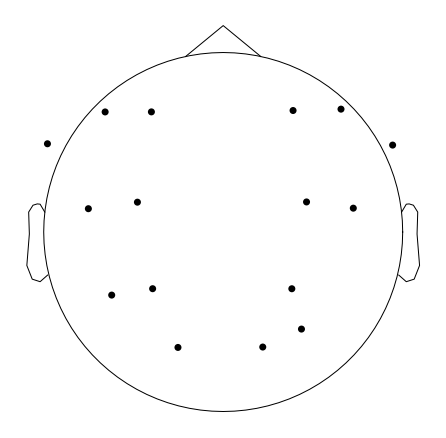

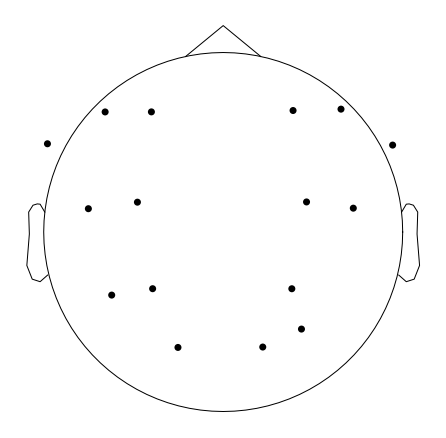

In [ ]:
epochs.plot_sensors()

###Fourier transform

must be done on each epoch seperately

In [ ]:
def fourier_transform(epoch, width_size):
  return mne.time_frequency.stft(epoch, width_size)

In [ ]:
def fourier_transform_all(epochs, width_size):
  new_epochs = []
  for epoch in epochs:
    new_epoch = fourier_transform(epoch, width_size)
    new_epochs.append(new_epoch)
  new_epochs = mne.concatenate(new_epochs)
  return new_epochs

In [ ]:
epochs = fourier_transform(epochs, 6)

# Having labels for EVERY epoch telling if it includes seizure or not 

Method: find the duration of seizure, find the duration of time before seizure, and divide by 5 to know how many EPOCHS are before the seizure, how many epochs are within seizure

Seizure start and end time need to be in context of the total time in the dataset, not just in the particular file

Problem: can only label this PER dataset

getting the total time from the dictionary of times by subtracting the last one from the first

In [ ]:
def get_total_time(file_order):
    #getting the keys
    times = file_order.keys()
    total = times[len(times) - 1] - times[0]
    return total

In [ ]:
def modify_seizure_names(seizure_names):
  new_names = []
  for name in seizure_names:
    fill, seizure_name = name.split("/")
    seizure_name = "Dataset/"  + seizure_name
    first, second = seizure_name.split("\\")
    seizure_name = first + "/" + second
    new_names.append(seizure_name)
  return new_names



getting the seizure file times 

In [ ]:
def get_seizure_files(names, seizure_names):
    files = []
    for name in names: 
        for seizure_name in seizure_names:
            if name == seizure_name: 
                beg, mid, end = name.split("/")
                files.append(end)
    return files
            

In [ ]:
def get_seizure_file_times(file_start, end, seizure_files, folder_name):
    seizure_start = []
    seizure_end = []
    names = get_value(file_start)
    for index in range(len(file_start)):
        name = names[index]
        for seizure_name in seizure_files:
            if seizure_name == name:
                seizure_start.append(get_key(file_start, name))
                seizure_end.append(end[index])
    return seizure_start, seizure_end

formatting the seizure start and end time

In [ ]:
def format_seizure_time(seizure_start, seizure_end, seizure_file_start, seizure_file_end):
    seizure_start_time = seizure_file_start + seizure_start
    seizure_end_time = seizure_file_end + seizure_end
    return seizure_start_time, seizure_end_time

In [ ]:
def format_seizure_times(seizure_start, seizure_end, seizure_file_start, seizure_file_end):
    seizure_start_times = []
    seizure_end_times = []
    for index in range(len(seizure_start)):
        seizure_start_time, seizure_end_time = format_seizure_time(seizure_start[index], seizure_end[index], seizure_file_start[index], seizure_file_end[index])
        seizure_start_times.append(seizure_start_time)
        seizure_end_times.append(seizure_end_time) 
    
    return seizure_start_times, seizure_end_times

Doing this because two of the seizure files have 2 seizures within them, so I have to dupicate those seizure file start and end times

Functions to get the labels of epochs based on the seizure start time and seizure end time

In [ ]:
def get_label(time_count, seizure_starts, seizure_ends):
    label = 0
    for index in range(len(seizure_starts)):
        if (time_count >= seizure_starts[index] and time_count <= seizure_ends[index]):
            label = 1
    return label

In [ ]:
def get_epoch_labels(epochs, seizure_start_time, seizure_end_time):
    #seizure time occurs in the total file time
    labels = []
    time_count = 0
    for epoch in epochs:
        labels.append(get_label(time_count, seizure_start_time, seizure_end_time))
        time_count += 5
    return labels

##Overall function to perform all the functions to get the labels

In [ ]:
def labels(epochs_array, folder, new_file_order, file_end, file_names, seizure_names, summary_file):
  seizure_names = modify_seizure_names(seizure_names)
  seizure_names.insert(0, "Dataset/chb01/chb01_03.edf")
  #getting the seizure files
  seizure_files = get_seizure_files(file_names, seizure_names)
  #getting seizure start and end times
  start, end = get_seizure_time(summary_file, seizure_files)
  #converting them into float arrays from string arrays
  start = convert_string_to_float(start)
  end = convert_string_to_float(end)
  #getting seizure FILE start and end times
  seizure_file_start, seizure_file_end = get_seizure_file_times(new_file_order, file_end, seizure_files, folder)
  index = 1
  first_dup = seizure_file_start[index]
  seizure_file_start.insert(index, first_dup)
  first_dup = seizure_file_end[index]
  seizure_file_end.insert(index, first_dup)
  index = len(seizure_file_start) - 1
  dup = seizure_file_start[index]
  seizure_file_start.insert(index, dup)
  seizure_file_start.insert(index, dup)
  seizure_file_start.insert(index, dup)
  dup = seizure_file_end[index]
  seizure_file_end.insert(index, dup)
  seizure_file_end.insert(index, dup)
  seizure_file_end.insert(index, dup)
  print(seizure_file_start)
  print(len(seizure_file_end))
  print(len(start))
  print(len(end))
  
  #formatting seizure file times (cause issues if multiple seizures in a file)
  seizure_start_times, seizure_end_times = format_seizure_times(start, end, seizure_file_start, seizure_file_end)
  #getting the labels
  epochs_labels = get_epoch_labels(epochs_array, seizure_start_times, seizure_end_times)
  #converting to numpy array
  epochs_labels = array_to_numpy(epochs_labels)
  #saving the labels
  save_file = f"label_files/{folder}_labels.pkl" 
  save_epochs(epochs_labels, save_file)
  


##Function to go thru every pkl file for epochs and getting the corresponding labels

In [ ]:
def make_all_labels():
  #getting each epoch file
  for epoch_file in os.listdir("epoch_files"):
    make_label_dataset(epoch_file)
   


In [ ]:
def make_label_dataset(epoch_file, seizure_names):
   #extracting epochs from pkl file
    epochs = load_epochs(epoch_file)
    #converting epochs to numpy array
    epochs_array = epochs.get_data()
    #getting folder name
    unnecessary, file_name = epoch_file.split("/")
    folder, suffix = file_name.split(".")
    #getting summary file
    summary = f"Dataset/{folder}/{folder}-summary.txt"
    #getting the new_file_order and file end
    new_file_order, file_end = sort_by_time(summary)
    #getting file_names
    ordered_files = get_value(new_file_order)
    file_names = format_file_names(ordered_files)
    #saving the labels
    labels(epochs_array, folder, new_file_order, file_end, file_names, seizure_names, summary)


In [ ]:
make_label_dataset("epoch_files/chb23.pkl", seizure_names)

[39763.0, 42356.0, 52827.0, 67273.0, 23308.0, 28325.0]
[32277.0, 42485.0, 42485.0, 52847.0, 52847.0, 52847.0, 52847.0]
7
7
7


###Function to transfer labels to where they would be sometime earlier

In [ ]:
def transfer_labels(time, epoch_labels, padding_time = 0):
  #note: time is in seconds
  shift_epochs = int(time / 5)
  padd_epochs = int(padding_time / 5)
  for index in range(len(epoch_labels)):
    #doesnt shift epoch labels if the seizure happens too early 
    if epoch_labels[index] == 1 and index - shift_epochs >= 0:
      epoch_labels[index - shift_epochs] = 1
      epoch_labels[index] = 0
  if padd_epochs > 0:
    do_padding(padd_epochs, epoch_labels)
   #padding time is to include sometime before/after the labels that are exactly "time"before the seizure, since seiuzres do not go for very long
  return epoch_labels

In [ ]:
def transfer_labels2(time, epoch_labels, padding_time = 0):
  #note: time is in seconds
  shift_epochs = int(time / 5)
  padd_epochs = int(padding_time / 5)
  for index in range(len(epoch_labels)):
    #doesnt shift epoch labels if the seizure happens too early 
    if epoch_labels[index] == 1 and index - shift_epochs >= 0:
      epoch_labels[index - shift_epochs] = 1
      #padding before
      for i in range(padd_epochs):
        if (index - (shift_epochs + padd_epochs) >= 0):
          epoch_labels[index - (shift_epochs + padd_epochs)] = 1
      epoch_labels[index] = 0
  return epoch_labels

In [ ]:
def do_padding(padd_epochs, epoch_labels):
  for index in range(len(epoch_labels)):
    if epoch_labels[index] == 1:
      #padding before
      epoch_count = 0
      while epoch_count < padd_epochs:
        epoch_labels[index - epoch_count] = 1
        epoch_labels[index + epoch_count]
      while epoch_labels[index] == 1:
        continue
  return epoch_labels


##Checking to see if there is a 1 indicating seizure in the labels

In [ ]:
def check_for_seizure(labels):
    for label in labels: 
        if label == 1:
            return True
    return False

##Using SPoC

In [ ]:
def spoc(epochs_array, epochs_labels, num_comp):
    spoc = mne.decoding.SPoC(num_comp)
    spoc_epochs = spoc.fit_transform(epochs_array, epochs_labels)
    return spoc_epochs

In [ ]:
def make_graph(epochs):
    #getting the three channels 
  
    epochs.plot(scalings = "auto")
    

In [ ]:
make_graph(epochs)

Working with epochs

Plotting epochs

In [ ]:
epochs.plot_psd(fmin=0.2, fmax = 40., average=True)

Epochs topomap

In [ ]:
epochs.plot_psd_topomap()

##Most algorithms want only a 2d array, so reshaping epochs to be a two dim array

In [ ]:
def make_2d(array):
    dim1, dim2, dim3 = array.shape
    array = np.reshape(array, (dim1, dim2 * dim3))
    return array

In [ ]:
epochs_2d = make_2d(epochs_array)

#Classification Algorithms

##1 K-Nearest Neighbors

In [ ]:
def knn(epochs, labels, num_neighbors, lim):
    model = classify.KNearestNeighbor(num_neighbors)
    model.fit(epochs[:lim], labels[:lim])
    preds = model.predict_proba(epochs[lim:])
    return preds



In [ ]:
labels = np.asarray(labels)

##Making a LSTM model

In [ ]:
def lstm(x_train, y_train, x_test, y_test, num_epochs):
  dim1, dim2, dim3 = x_train.shape
  model = keras.Sequential()
  
  model.add(LSTM(128, return_sequences = True, activation = "tanh", input_shape = (dim2, dim3)))
  #latest addition: adding dropout layers
  #model.add(Dropout(0.2))
  model.add(LSTM(16, activation = 'tanh', input_shape = (128,)))
  #model.add(Dropout(0.2))
  model.add(Dense(22, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4), activity_regularizer=regularizers.L2(1e-5), activation = 'relu'))
  
  model.add(Dense(1, activation = 'sigmoid')) # change activation to sigmoid to keep values close to either 0 or 1 for binary classification
  model.add(Flatten())
  model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = [keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.FalsePositives(), keras.metrics.FalseNegatives(), keras.metrics.TruePositives(), keras.metrics.TrueNegatives()]) # change loss function to BCE loss (binary crossentropy loss) to match with sigmoid
  #fitting model to training data and validating with test data
  model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = num_epochs)
  

In [ ]:
lstm(epochs_array[:200000], labels[:200000], epochs_array[200000:230000], labels[200000:230000], 30)

Epoch 1/30
6250/6250 [==============================] - 58s 8ms/step - loss: 0.6397 - binary_accuracy: 0.6641 - precision: 0.4615 - recall: 8.9302e-05 - false_positives: 7.0000 - false_negatives: 67182.0000 - true_positives: 6.0000 - true_negatives: 132805.0000 - val_loss: 0.6168 - val_binary_accuracy: 0.6950 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_false_negatives: 9149.0000 - val_true_positives: 0.0000e+00 - val_true_negatives: 20851.0000
Epoch 2/30
6250/6250 [==============================] - 45s 7ms/step - loss: 0.6385 - binary_accuracy: 0.6641 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - false_negatives: 67188.0000 - true_positives: 0.0000e+00 - true_negatives: 132812.0000 - val_loss: 0.6201 - val_binary_accuracy: 0.6950 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_false_negatives: 9149.0000 - val_true_positives: 0.0000e+00 - val_true_negatives: 20851

##SVM

In [ ]:
def SVM(x_train, y_train, x_test, y_test):
  model = sklearn.svm.SVC()
  model.fit(x_train, y_train)
  y_preds = model.predict(x_test)
  score = sklearn.metrics.accuracy_score(y_test, y_preds)
  return score

In [ ]:
score = SVM(epochs_2d[:20000], labels[:20000], epochs_2d[20000:50000], labels[20000:50000])

##K Nearest Neighbors

In [ ]:
def knn(x_train, y_train, x_test, y_test):
  model = sklearn.neighbors.KNeighborsClassifier()
  model.fit(x_train, y_train)
  y_preds = model.predict(x_test)
  score = sklearn.metrics.accuracy_score(y_test, y_preds)
  return score

In [ ]:
score = knn(epochs_2d[:200000], labels[:200000], epochs_2d[200000:230000], labels[200000:230000])

In [ ]:
print(score)

0.6987666666666666


##Logistic Regression

In [ ]:
def logistic_regression(x_train, y_train, x_test, y_test):
  model = sklearn.linear_model.LogisticRegression()
  model.fit(x_train, y_train)
  y_preds = model.predict(x_test)
  score = sklearn.metrics.accuracy_score(y_test, y_preds)
  return score

In [ ]:
score = logistic_regression(epochs_2d[:200000], labels[:200000], epochs_2d[200000:230000], labels[200000:230000])

In [ ]:
print(score)

0.7084333333333334


##Decision Tree

In [ ]:
def decision_tree(x_train, y_train, x_test, y_test):
  model = sklearn.tree.DecisionTreeClassifier()
  model.fit(x_train, y_train)
  y_preds = model.predict(x_test)
  score = sklearn.metrics.accuracy_score(y_test, y_preds)
  return score

In [ ]:
score = decision_tree(epochs_2d[:200000], labels[:200000], epochs_2d[200000:230000], labels[200000:230000])

AttributeError: ignored

In [ ]:
print(score)

##Transformers

In [ ]:
%pip install keras_nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.5/337.5 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 73.2 MB/s eta 0:00:00


In [ ]:
import keras_nlp

In [ ]:
def transformer(x_train, y_train, x_test, y_test, num_epochs):
  dim1, dim2, dim3 = x_train.shape
  encoder = keras_nlp.layers.TransformerEncoder(intermediate_dim=64, num_heads=8)
  decoder = keras_nlp.layers.TransformerDecoder(intermediate_dim=64, num_heads=8)
  input = keras.Input(shape=[dim2, dim3])
  output = encoder(input)
  #output = decoder(encoder_input)
  model = keras.Model(inputs=input, outputs=output)
  model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = [keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.FalsePositives(), keras.metrics.FalseNegatives(), keras.metrics.TruePositives(), keras.metrics.TrueNegatives()])
  model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = num_epochs)

In [ ]:
from transformers import TFAutoModel, AutoTokenizer

In [ ]:
def transformer2(x_train, y_train, x_test, y_test, num_epochs):
  dim1, dim2, dim3 = x_train.shape
  # Define the model
  input_shape = (dim2, dim3) # shape of input data
  output_sequence_length = len(y_test) # length of output sequence
  input_tensor = keras.layers.Input(shape=input_shape)
  encoder_output = keras.layers.TransformerEncoder(32, 2)(input_tensor)
  decoder_output = keras.layers.TransformerDecoder(32, 2, output_sequence_length)(encoder_output)
  output_tensor = keras.layers.Dense(1)(decoder_output)
  model = keras.Model(input_tensor, output_tensor)
  model.summary()

  model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = [keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.FalsePositives(), keras.metrics.FalseNegatives(), keras.metrics.TruePositives(), keras.metrics.TrueNegatives()])
  model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = num_epochs)

  

In [ ]:
transformer2(epochs_array[:200000], labels[:200000], epochs_array[200000:230000], labels[200000:230000], 30)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initiali

ValueError: ignored

## recurrent neural network

In [ ]:
def rnn(x_train, y_train, x_test, y_test, num_epochs):
  dim1, dim2, dim3 = x_train.shape
  model = keras.Sequential()
  
  model.add(SimpleRNN(128, return_sequences = True, activation = "tanh", input_shape = (dim2, dim3)))
  #latest addition: adding dropout layers
  #model.add(Dropout(0.2))
  model.add(SimpleRNN(16, activation = 'tanh', input_shape = (128,)))
  #model.add(Dropout(0.2))
  model.add(Dense(22, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4), activity_regularizer=regularizers.L2(1e-5), activation = 'relu'))
  
  model.add(Dense(1, activation = 'sigmoid')) # change activation to sigmoid to keep values close to either 0 or 1 for binary classification
  model.add(Flatten())
  model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = [keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.FalsePositives(), keras.metrics.FalseNegatives(), keras.metrics.TruePositives(), keras.metrics.TrueNegatives()]) # change loss function to BCE loss (binary crossentropy loss) to match with sigmoid
  #fitting model to training data and validating with test data
  model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = num_epochs)
  

In [ ]:
rnn(epochs_array[:200000], labels[:200000], epochs_array[200000:230000], labels[200000:230000], 30)

Epoch 1/30
6250/6250 [==============================] - 106s 16ms/step - loss: 0.6404 - binary_accuracy: 0.6640 - precision: 0.4429 - recall: 4.6139e-04 - false_positives: 39.0000 - false_negatives: 67157.0000 - true_positives: 31.0000 - true_negatives: 132773.0000 - val_loss: 0.6176 - val_binary_accuracy: 0.6950 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_false_negatives: 9149.0000 - val_true_positives: 0.0000e+00 - val_true_negatives: 20851.0000
Epoch 2/30
6250/6250 [==============================] - 95s 15ms/step - loss: 0.6394 - binary_accuracy: 0.6641 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 1.0000 - false_negatives: 67188.0000 - true_positives: 0.0000e+00 - true_negatives: 132811.0000 - val_loss: 0.6212 - val_binary_accuracy: 0.6950 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_false_negatives: 9149.0000 - val_true_positives: 0.0000e+00 - val_true_negatives: 2085

Gradient Boosting machine

In [ ]:
def gbm(x_train, y_train, x_test, y_test):
  model = sklearn.ensemble.GradientBoostingClassifier()
  model.fit(x_train, y_train)
  preds = model.predict(x_test)
  score = sklearn.metrics.accuracy_score(y_test, preds)
  return score


In [ ]:
score = gbm(epochs_2d[:200000], labels[:200000], epochs_2d[200000:230000], labels[200000:230000])

NameError: ignored

In [ ]:
print(score)

In [ ]:
from keras.layers import Conv1D

##CNN

In [ ]:
def cnn(x_train, y_train, x_test, y_test, num_epochs):
  dim1, dim2, dim3 = x_train.shape
  print(dim3)
  model = keras.Sequential()
  
  model.add(Conv1D(2, 10, activation = "relu", input_shape = (dim2, dim3)))
  #latest addition: adding dropout layers
  #model.add(Dropout(0.2))
  #model.add(Conv1D(16, 50, activation = 'relu'))
  #model.add(Dropout(0.2))
  model.add(Dense(22, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4), activity_regularizer=regularizers.L2(1e-5), activation = 'relu'))
  
  model.add(Dense(1, activation = 'sigmoid')) # change activation to sigmoid to keep values close to either 0 or 1 for binary classification
  model.add(Flatten())
  model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = [keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.FalsePositives(), keras.metrics.FalseNegatives(), keras.metrics.TruePositives(), keras.metrics.TrueNegatives()]) # change loss function to BCE loss (binary crossentropy loss) to match with sigmoid
  #fitting model to training data and validating with test data
  model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = num_epochs)
  

In [ ]:
cnn(epochs_array[:200000], labels[:200000], epochs_array[200000:230000], labels[200000:230000], 30)

NameError: ignored


# Convert EDF file to csv

In [ ]:
import numpy as np
import mne
import pandas as pd

In [ ]:
edf = mne.io.read_raw_edf('/content/drive/Shareddrives/blisssinghal-dataset/Dataset/chb01/chb01_01.edf')
header = ','.join(edf.ch_names)
np.savetxt('/content/drive/Shareddrives/blisssinghal-dataset/CSV Dataset/chb01_01.csv', edf.get_data().T, delimiter=',', header=header)

Extracting EDF parameters from /content/drive/Shareddrives/blisssinghal-dataset/Dataset/chb01/chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-53-c9ed2860c682>:3: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf('/content/drive/Shareddrives/blisssinghal-dataset/Dataset/chb01/chb01_01.edf')


In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/blisssinghal-dataset/CSV Dataset/chb01_01.csv')
df.head()

,# FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,F4-C4,...,F8-T8,T8-P8-0,P8-O2,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8-1
0,-1.459341e-04,-1.045177e-04,-4.278388e-05,-3.301587e-05,-1.709402e-04,-1.107692e-04,1.191697e-05,-5.645910e-05,-1.392918e-04,-1.367521e-06,...,5.724054e-05,4.473748e-05,7.482295e-05,-1.060806e-04,8.459096e-05,4.317460e-05,-5.724054e-05,-2.647131e-04,9.474969e-05,4.473748e-05
1,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,...,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07
2,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,...,1.953602e-07,1.953602e-07,-1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,5.860806e-07,1.953602e-07,1.953602e-07
3,1.953602e-07,5.860806e-07,1.953602e-07,5.860806e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,...,1.367521e-06,1.953602e-07,-2.148962e-06,1.953602e-07,1.953602e-07,1.953602e-07,-5.860806e-07,1.758242e-06,1.953602e-07,1.953602e-07
4,1.953602e-07,1.953602e-07,1.953602e-07,-1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,1.953602e-07,...,1.953602e-07,1.953602e-07,9.768010e-07,1.953602e-07,1.953602e-07,1.953602e-07,5.860806e-07,-2.148962e-06,1.953602e-07,1.953602e-07


In [ ]:
len(df)

921600